# Recreates Variational AutoEncoder model in Chapter 3 of "Generative Deep Learning" by Foster (MNIST)

# Get MNIST data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./Data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./Data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/MNIST/raw



# Visualize an image

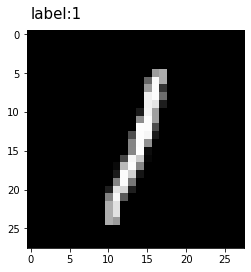

torch.Size([28, 28])

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def my_imshow(img, label, prediction=None):
    npimg = img.numpy()
    plt.imshow(img, cmap='gray')
    plt.text(0, -2, f'label:{label}', fontsize=15)
    if prediction: 
      plt.text(20, -2, f'pred:{prediction}', fontsize=15)
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
idx = 0
my_imshow(torch.squeeze(images[idx], 0), classes[labels[idx]])
torch.squeeze(images[idx], 0).shape

# Model architecture for Encoder

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Encoder(nn.Module):
    def __init__(self, in_channels, conv_channels, conv_filters, 
                 conv_strides, dense_units_in, dense_units_out):
        super(Encoder, self).__init__()


        self.conv0 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=conv_channels[0], 
                               kernel_size=conv_filters[0], stride=conv_strides[0], 
                               padding='same')
        
        for i in range(1, len(conv_channels)):
            exec(f"""self.conv{i} = nn.Conv2d(in_channels=conv_channels[i-1], 
                        out_channels=conv_channels[i], 
                        kernel_size=conv_filters[i], stride=conv_strides[i], 
                        padding=1 if conv_strides[i] > 1 else 'same')"""
            )
        
        self.flatten1 = nn.Flatten()
        self.mu = nn.Linear(in_features=dense_units_in[0], out_features=dense_units_out[0], bias=True)    
        self.log_var = nn.Linear(in_features=dense_units_in[0], out_features=dense_units_out[0], bias=True)  


    def forward(self, x):
        x = F.leaky_relu(self.conv0(x))
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.flatten1(x) 
        x_mu = self.mu(x)
        x_log_var = self.log_var(x)
        return [x_mu, x_log_var]
          

conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]
dense_units_out = [2]
dense_units_in = [3136]
my_encoder = Encoder(in_channels=1, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units_in=dense_units_in, dense_units_out=dense_units_out)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
my_encoder = my_encoder.to(device)
summary(my_encoder, input_size=(1, 28, 28))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Conv2d-4             [-1, 64, 7, 7]          36,928
           Flatten-5                 [-1, 3136]               0
            Linear-6                    [-1, 2]           6,274
            Linear-7                    [-1, 2]           6,274
Total params: 105,220
Trainable params: 105,220
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 0.40
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


# Model Architecture for Decoder

In [5]:
class Decoder(nn.Module):

  def __init__(self, in_dim, tconv_channels, tconv_filters, tconv_strides, 
               dense_units, output_padding, batch_size=2):
    super().__init__()
    self.batch_size=batch_size
    self.dense1 = nn.Linear(in_dim, dense_units[0])
    
    self.tconv0 = nn.ConvTranspose2d(in_channels=64, 
                                     out_channels=tconv_channels[0], 
                                     kernel_size=tconv_filters[0], 
                                     stride=tconv_strides[0], 
                                     padding=1, output_padding=output_padding[0])

    for i in range(1, len(tconv_channels)):
      exec(f"""self.tconv{i} = nn.ConvTranspose2d(in_channels=tconv_channels[i-1], 
                        out_channels=tconv_channels[i], 
                        kernel_size=tconv_filters[i], stride=tconv_strides[i], 
                        padding=1,
                        output_padding=output_padding[i])"""
          )
    
  def forward(self, x):
    x = self.dense1(x)
    x = torch.reshape(x, [-1, 64, 7, 7])

    x = F.leaky_relu(self.tconv0(x))
    x = F.leaky_relu(self.tconv1(x))
    x = F.leaky_relu(self.tconv2(x))
    x = torch.sigmoid(self.tconv3(x))
    return x


tconv_channels = [64, 64, 32, 1]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [1, 2, 2, 1]
dense_units = [3136]
output_padding=[0,1,1,0]
my_decoder = Decoder(in_dim=2, tconv_channels=tconv_channels, 
             tconv_filters=tconv_filters, tconv_strides=tconv_strides, 
             dense_units=dense_units, output_padding=output_padding)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
my_decoder = my_decoder.to(device)
summary(my_decoder, input_size=(2,))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3136]           9,408
   ConvTranspose2d-2             [-1, 64, 7, 7]          36,928
   ConvTranspose2d-3           [-1, 64, 14, 14]          36,928
   ConvTranspose2d-4           [-1, 32, 28, 28]          18,464
   ConvTranspose2d-5            [-1, 1, 28, 28]             289
Total params: 102,017
Trainable params: 102,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 0.39
Estimated Total Size (MB): 0.73
----------------------------------------------------------------


# Model Architecture for Variational AutoEncoder

In [35]:
from torch.distributions.multivariate_normal import MultivariateNormal

class VarAutoEncoder(nn.Module):

    def __init__(self, in_channels, dec_in_dim, conv_channels, conv_filters, conv_strides, 
                       enc_dense_in, enc_dense_out, tconv_channels, tconv_filters, tconv_strides,
                       dec_dense_units, output_padding):
      super().__init__()
      self.encoder = Encoder(in_channels=in_channels, conv_channels=conv_channels, 
             conv_filters=conv_filters, conv_strides=conv_strides, 
             dense_units_in=enc_dense_in, dense_units_out=enc_dense_out)
      self.decoder = Decoder(in_dim=dec_in_dim, tconv_channels=tconv_channels, 
             tconv_filters=tconv_filters, tconv_strides=tconv_strides, 
             dense_units=dense_units, output_padding=output_padding, batch_size=32)
      self.normal_dist = MultivariateNormal(torch.zeros(enc_dense_out[0]), torch.eye(enc_dense_out[0]))   
       

    def forward(self, x, decode=True):
      mu, log_var = self.encoder(x)
      epsilon = self.normal_dist.sample((x.shape[0],))
      epsilon = epsilon.to(device)
      z = mu + (torch.sqrt(torch.exp(log_var)) / 2) * epsilon # z = mu + sqrt(exp(log_var)) / 2 * epsilon where epsilon ~ N(0,1)
      if not decode:
        return [z, mu, log_var]

      return [self.decoder(z), mu, log_var]



tconv_channels = [64, 64, 32, 1]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [1, 2, 2, 1]
dec_dense_units = [3136]
output_padding=[0,1,1,0]
conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]
enc_dense_out = [2]
enc_dense_in = [3136]

my_auto_encoder = VarAutoEncoder(1, 2, conv_channels, conv_filters, conv_strides, 
                              enc_dense_in, enc_dense_out, tconv_channels, tconv_filters, 
                              tconv_strides,dec_dense_units, output_padding)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
my_auto_encoder = my_auto_encoder.to(device)
summary(my_auto_encoder, input_size=(1,28,28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Conv2d-4             [-1, 64, 7, 7]          36,928
           Flatten-5                 [-1, 3136]               0
            Linear-6                    [-1, 2]           6,274
            Linear-7                    [-1, 2]           6,274
           Encoder-8         [[-1, 2], [-1, 2]]               0
            Linear-9                 [-1, 3136]           9,408
  ConvTranspose2d-10             [-1, 64, 7, 7]          36,928
  ConvTranspose2d-11           [-1, 64, 14, 14]          36,928
  ConvTranspose2d-12           [-1, 32, 28, 28]          18,464
  ConvTranspose2d-13            [-1, 1, 28, 28]             289
          Decoder-14            [-

# Custom Loss Function

In [48]:
class VAELoss(nn.Module):
    def __init__(self, weight=1.0, use_KL=True):
        super(VAELoss, self).__init__()
        self.rec_weight = weight
        self.reconstruction_loss = nn.MSELoss(reduction='none')
        self.kl_weight = 1.0 if use_KL else 0

    def forward(self, output, target, mu, log_var):
        vae_loss_reconstruction = torch.sum(self.reconstruction_loss(output, target))
        vae_loss_kl = -0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - torch.exp(log_var), dim=1)
        vae_loss = vae_loss_reconstruction * self.rec_weight + vae_loss_kl * self.kl_weight
        return torch.sum(vae_loss)

In [49]:
import math

# Test everything manually

# Manually do the sampling
x = images[0:5].to(device)
print(x.shape)
#x = x.unsqueeze(0)
mu, log_var = my_encoder(x)
epsilon = MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((x.shape[0],)) 
epsilon = epsilon.to(device)
z = mu + (torch.sqrt(torch.exp(log_var)) / 2) * epsilon
y = my_decoder(z)
print(f'input shape: {x.shape}')
print(f'encoded mu shape: {mu.shape}')
print(f'encoded log_var shape: {log_var.shape}')
print(f'sample shape: {z.shape}')
print(f'decoded output shape: {y.shape}')


# Sample from within autoencoder
y, mu, log_var = my_auto_encoder(x, decode=True)
z, _, _ = my_auto_encoder(x, decode=False)
print()
print(f'input shape: {x.shape}')
print(f'encoded mu shape: {mu.shape}')
print(f'encoded log_var shape: {log_var.shape}')
print(f'sample shape: {z.shape}')
print(f'decoded output shape: {y.shape}')

# Test loss function
criterion = VAELoss(weight=0.5, use_KL=True)
loss = criterion(y, x, mu, log_var)
print()
print(f'mu: {mu}')
print(f'log_var: {log_var}')
print(f'loss (with KL): {loss.item()}')
criterion = VAELoss(weight=0.5, use_KL=False)
loss = criterion(y, x, mu, log_var)
print(f'loss (without KL): {loss.item()}')

torch.Size([5, 1, 28, 28])
input shape: torch.Size([5, 1, 28, 28])
encoded mu shape: torch.Size([5, 2])
encoded log_var shape: torch.Size([5, 2])
sample shape: torch.Size([5, 2])
decoded output shape: torch.Size([5, 1, 28, 28])

input shape: torch.Size([5, 1, 28, 28])
encoded mu shape: torch.Size([5, 2])
encoded log_var shape: torch.Size([5, 2])
sample shape: torch.Size([5, 2])
decoded output shape: torch.Size([5, 1, 28, 28])

mu: tensor([[ 2.0337,  2.5252],
        [-0.0132, -0.4144],
        [-1.2791,  0.6362],
        [ 0.0194,  0.2741],
        [-0.7783,  0.3717]], device='cuda:0', grad_fn=<AddmmBackward0>)
log_var: tensor([[-1.7350, -1.4960],
        [-2.5103, -1.8806],
        [-1.2204, -2.4796],
        [-1.7003, -0.8471],
        [-1.5488, -2.1083]], device='cuda:0', grad_fn=<AddmmBackward0>)
loss (with KL): 359.32891845703125
loss (without KL): 347.81427001953125


# Training

In [50]:
def calculate_test_loss(autoencoder, test_loader, criterion, device):
    autoencoder.eval()
    with torch.no_grad(): 
 
        reconstructed_images = []
        original_images = []
        test_loss_total = 0
  
        for images, labels in test_loader:
            images = images.to(device)
            y, mu, log_var = autoencoder(images)
            loss = criterion(y, images, mu, log_var)
            test_loss_total += loss.item()

    return test_loss_total



In [38]:
from tqdm.notebook import tqdm
import torch.optim as optim

torch.manual_seed(555)
epochs = 12
#criterion = nn.MSELoss()
criterion = VAELoss(weight=0.009, use_KL=True)
optimizer = optim.Adam(my_auto_encoder.parameters(), lr=0.001)

train_loss_epoch = []
test_loss_epoch = []
for epoch in tqdm(range(1, epochs+1)):
  my_auto_encoder.train()
  loss_train_total = 0
  train_loss_batch = []

  progress_bar = tqdm(trainloader, desc=f'epoch: {epoch}', leave=False, disable=False)
  for batch in progress_bar:

    my_auto_encoder.zero_grad()

    batch = tuple(b.to(device) for b in batch)
    images, labels = batch[0], batch[1]
    
    my_auto_encoder.to(device)

    reconstructed_images, mu, log_var = my_auto_encoder(images)
    loss = criterion(reconstructed_images, images, mu, log_var)
    loss_train_total += loss.item()
    train_loss_batch.append(loss.item())

    loss.backward()
    optimizer.step()

    progress_bar.set_postfix(
        {
            'training_loss (per image in current batch)': '{:.3f}'.format(loss.item()/len(batch))
        }
    )

  
  tqdm.write(f'\nEpoch: {epoch}')

  loss_train_avg = loss_train_total / len(trainloader)
  train_loss_epoch.append(loss_train_avg)
  tqdm.write(f'Avg Training Loss: {loss_train_avg}')

  test_loss_avg = calculate_test_loss(my_auto_encoder, testloader, criterion, device) / len(testloader)
  test_loss_epoch.append(test_loss_avg)
  tqdm.write(f'Avg Test Loss: {test_loss_avg}')



  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 1
Avg Training Loss: 424.529174609375
Avg Test Loss: 407.64869341378017


epoch: 2:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 2
Avg Training Loss: 404.7350131184896
Avg Test Loss: 401.87285280075315


epoch: 3:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 3
Avg Training Loss: 400.3997661783854
Avg Test Loss: 401.408473444442


epoch: 4:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 4
Avg Training Loss: 397.4183724446615
Avg Test Loss: 394.78851581610047


epoch: 5:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 5
Avg Training Loss: 395.11629334309896
Avg Test Loss: 394.3172659340758


epoch: 6:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 6
Avg Training Loss: 393.69266316731773
Avg Test Loss: 393.1529087151963


epoch: 7:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 7
Avg Training Loss: 392.3056189453125
Avg Test Loss: 389.67150401155027


epoch: 8:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 8
Avg Training Loss: 391.60303134765627
Avg Test Loss: 391.65188569382735


epoch: 9:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 9
Avg Training Loss: 390.47619415690104
Avg Test Loss: 388.44342353016424


epoch: 10:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 10
Avg Training Loss: 389.748741796875
Avg Test Loss: 387.40850286514234


epoch: 11:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 11
Avg Training Loss: 389.02486692708334
Avg Test Loss: 386.955362094477


epoch: 12:   0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 12
Avg Training Loss: 388.3654402994792
Avg Test Loss: 388.267507412944


# Loss Curves on Train/Test




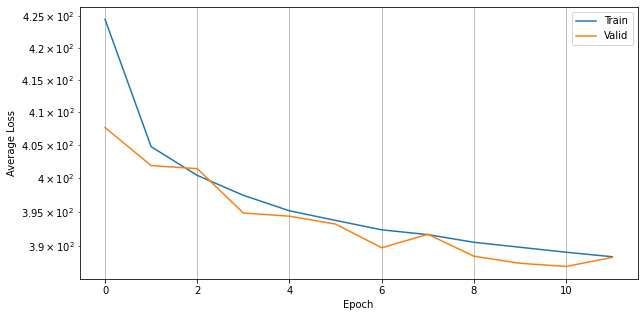

In [39]:
plt.figure(figsize=(10,5))
plt.semilogy(train_loss_epoch, label='Train')
plt.semilogy(test_loss_epoch, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid()
plt.legend()
plt.show()

# Save/Load the model

In [40]:
from google.colab import drive
drive.mount('/content/drive/')

torch.save(my_auto_encoder.state_dict(), '/content/drive/My Drive/Models/MNIST_VAE_epoch10.model')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
tconv_channels = [64, 64, 32, 1]
tconv_filters = [3, 3, 3, 3]
tconv_strides = [1, 2, 2, 1]
dec_dense_units = [3136]
output_padding=[0,1,1,0]
conv_channels = [32, 64, 64, 64]
conv_filters = [3, 3, 3, 3]
conv_strides = [1, 2, 2, 1]
enc_dense_out = [2]
enc_dense_in = [3136]

my_auto_encoder = VarAutoEncoder(1, 2, conv_channels, conv_filters, conv_strides, 
                              enc_dense_in, enc_dense_out, tconv_channels, tconv_filters, 
                              tconv_strides,dec_dense_units, output_padding)

my_auto_encoder.load_state_dict(torch.load('/content/drive/My Drive/Models/MNIST_VAE_epoch10.model'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_auto_encoder = my_auto_encoder.to(device)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Visualize Encoded Space

In [41]:
def autoencode_images(autoencoder, dataloader, device):
    autoencoder.eval()
    with torch.no_grad(): 
 
        encoded_images = []
        original_labels = []
        original_images = []
        reconstructed_images = []

        for images, labels in dataloader: 
            images = images.to(device)
            outputs_encoded, _, _ = autoencoder(images, decode=False)
            outputs_decoded, _, _ = autoencoder(images, decode=True)

            reconstructed_images.append(outputs_decoded.cpu())
            encoded_images.append(outputs_encoded.cpu())
            original_labels.append(labels.cpu())
            original_images.append(images.cpu())
  

    return original_images, original_labels, encoded_images, reconstructed_images

original_images, original_labels, encoded_images, reconstructed_images = (
    autoencode_images(my_auto_encoder, testloader, device)
)
original_images = torch.cat(original_images, 0)
original_labels = torch.cat(original_labels, 0)
encoded_images = torch.cat(encoded_images, 0)
reconstructed_images = torch.cat(reconstructed_images, 0)

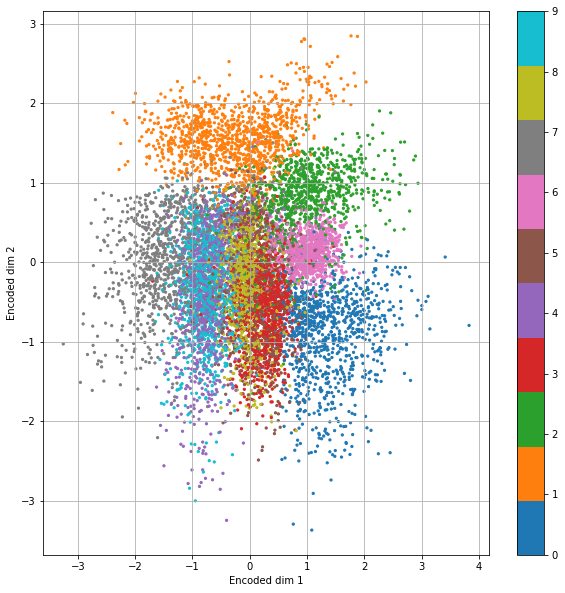

In [42]:
plt.figure(figsize=(10,10))

plt.scatter(encoded_images[:,0].numpy(), encoded_images[:,1], c=original_labels, cmap='tab10', s=5)
plt.colorbar(ticks=np.linspace(0, 10, 11))
plt.xlabel('Encoded dim 1')
plt.ylabel('Encoded dim 2')
plt.grid()

plt.show()


# Visualize Reconstructed images from Test set


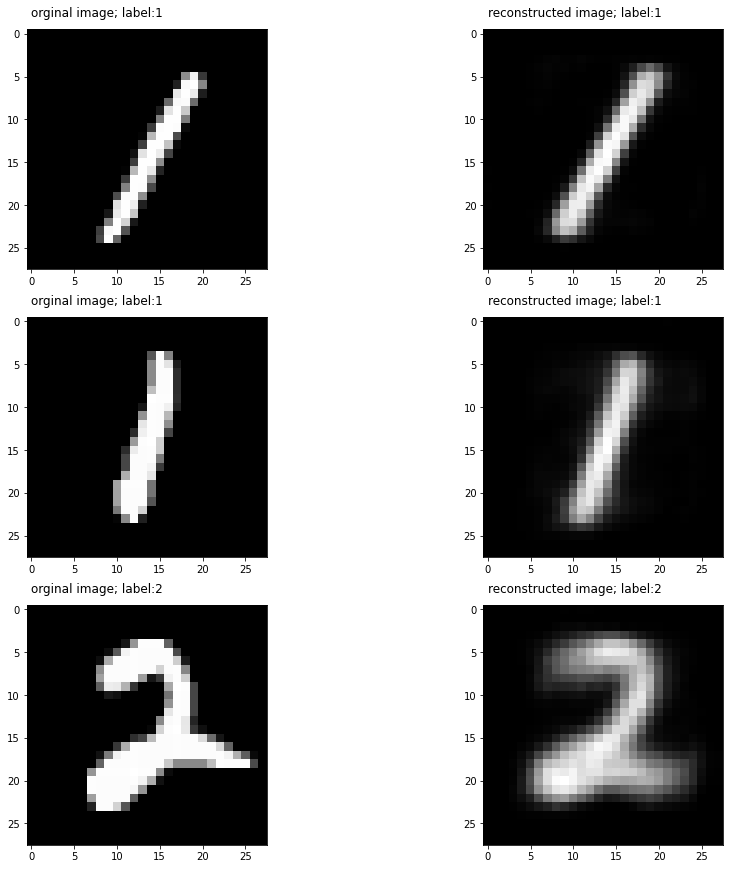

In [56]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

for i in range(3):
    idx = np.random.choice(range(original_images.shape[0]), size=1)[0]
    img = torch.squeeze(original_images[idx], 0)
    axs[i,0].imshow(img.numpy(), cmap='gray')
    axs[i,0].text(0, -2, f'orginal image; label:{classes[original_labels[idx]]}', fontsize=12)

    img = torch.squeeze(reconstructed_images[idx], 0)
    axs[i,1].imshow(img.numpy(), cmap='gray')
    axs[i,1].text(0, -2, f'reconstructed image; label:{classes[original_labels[idx]]}', fontsize=12)




# Generate novel images

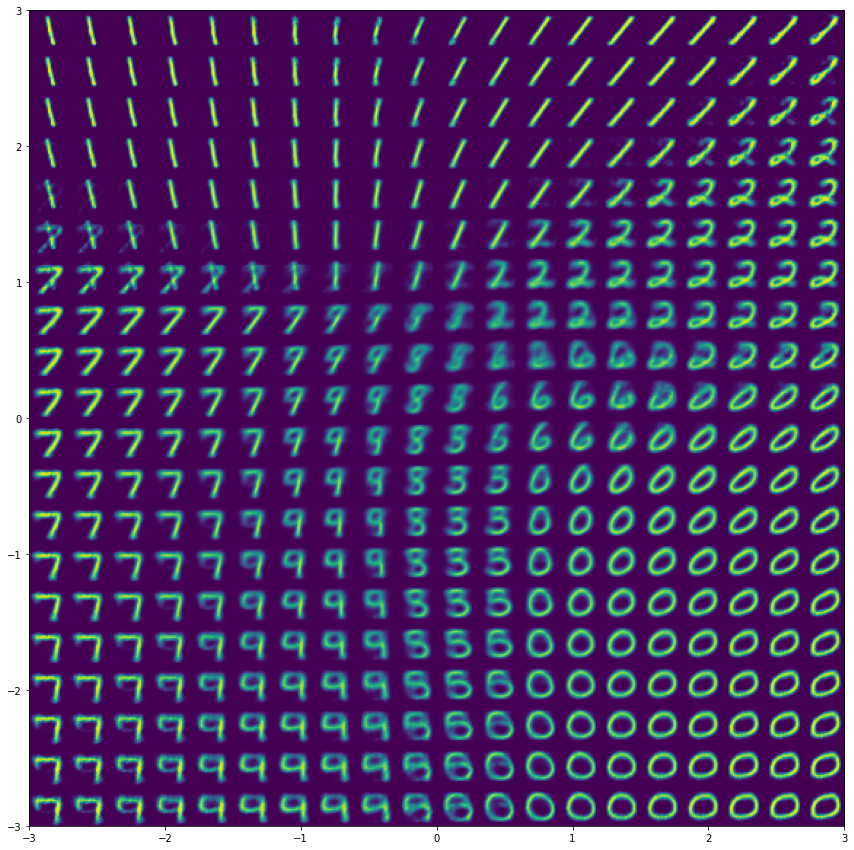

In [47]:
# plot function adapted from from https://avandekleut.github.io/vae/
def plot_reconstructed(autoencoder, r0=(-2, 2), r1=(-2, 2), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.figure(figsize=(15,15))
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(my_auto_encoder, r0=(-3, 3), r1=(-3,3), n=20)